In [9]:
!python --version

Python 3.12.12


In [10]:
import os
import random
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import glob

src_dir = "/content/drive/MyDrive/retinopathy dataset"

# Récupère toutes les images dans tous les sous-dossiers
all_images = glob.glob(src_dir + "/*/*.jpeg")  # change .jpg selon ton format (.png, etc.)

print("Nombre d'images :", len(all_images))
print("Exemple d'images :", all_images[:5])


Nombre d'images : 35112
Exemple d'images : ['/content/drive/MyDrive/retinopathy dataset/batch_1/11165_right.jpeg', '/content/drive/MyDrive/retinopathy dataset/batch_1/11169_left.jpeg', '/content/drive/MyDrive/retinopathy dataset/batch_1/11161_right.jpeg', '/content/drive/MyDrive/retinopathy dataset/batch_1/11129_left.jpeg', '/content/drive/MyDrive/retinopathy dataset/batch_1/11161_left.jpeg']


In [12]:
import glob
import os
import re
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Paths
DIRECTORY = "/content/drive/MyDrive/retinopathy dataset"  # parent folder with 18 subfolders
LABELS_FILE = "/content/drive/MyDrive/trainLabels_cropped.csv"

# Load labels
labels_df = pd.read_csv(LABELS_FILE)
labels_dict = dict(zip(labels_df['image'], labels_df['level']))

# Collect all images in all subfolders
all_files = glob.glob(os.path.join(DIRECTORY, "**", "*.jpeg"), recursive=True)

images = []
labels = []
train_image_count = 0

for filepath in all_files:
    filename = os.path.basename(filepath)  # only keep filename
    if train_image_count < 1000:  # limit for testing
        img = load_img(filepath, target_size=(256, 256))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)

        # match labels
        base_name = re.sub(r'\s*\(.*\)', '', filename.split('.')[0])
        label = labels_dict.get(base_name)

        if label is not None:
            labels.append(label)
            train_image_count += 1
        else:
            images.pop()  # skip if no label found

# Convert to arrays
images = np.array(images)
labels = np.array(labels)

# One-hot encoding
labels = to_categorical(labels, num_classes=5)

print("Loaded", images.shape[0], "images with labels")


Loaded 1000 images with labels


In [13]:
images.shape

(1000, 256, 256, 3)

In [14]:
labels.shape

(1000, 5)

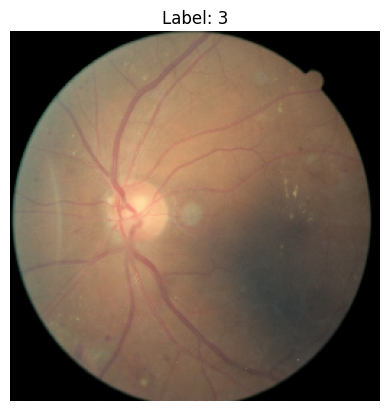

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(images[999])
plt.title(f"Label: {np.argmax(labels[999])}")  # Convert from one-hot to class index
plt.axis('off')
plt.show()

In [15]:
images_flat = images.reshape((images.shape[0], -1))  # Shape: (n_train, 256*256*3)

In [16]:
labels_flat = np.argmax(labels, axis=1)

In [17]:
images_flat.shape

(1000, 196608)

#sequential kmeans

In [ ]:
class cust_K_Means(object):
    def __init__(self, n_clusters, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol  # Convergence tolerance
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.number_of_iter = 0

    def _initialize_centroids(self, X):
        """Randomly select initial centroids"""
        indices = np.random.permutation(X.shape[0])[:self.n_clusters]
        return X[indices].copy()

    def _compute_distances(self, X, centers):
        """
        Vectorized distance computation - MUCH faster!
        Returns: (n_samples, n_clusters) array of distances
        """
        # Expand dimensions for broadcasting
        # X: (n_samples, n_features) -> (n_samples, 1, n_features)
        # centers: (n_clusters, n_features) -> (1, n_clusters, n_features)
        distances = np.sqrt(((X[:, np.newaxis, :] - centers[np.newaxis, :, :]) ** 2).sum(axis=2))
        return distances

    def _assign_clusters(self, X, centers):
        """Assign each point to nearest cluster - VECTORIZED"""
        distances = self._compute_distances(X, centers)
        return np.argmin(distances, axis=1)

    def _compute_centroids(self, X, labels):
        """Compute new centroids - VECTORIZED"""
        new_centers = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            cluster_points = X[labels == k]
            if len(cluster_points) > 0:
                new_centers[k] = cluster_points.mean(axis=0)
            else:
                # Handle empty cluster - reinitialize randomly
                new_centers[k] = X[np.random.randint(X.shape[0])]
        return new_centers


    def fit(self, X):
        """Train K-Means on data X"""
        X = np.array(X)

        # Initialize centroids
        self.cluster_centers_ = self._initialize_centroids(X)

        for i in range(self.max_iter):
            # Assign points to clusters
            labels = self._assign_clusters(X, self.cluster_centers_)

            # Compute new centroids
            new_centers = self._compute_centroids(X, labels)

            # Check convergence (centroid shift)
            center_shift = np.sqrt(((new_centers - self.cluster_centers_) ** 2).sum())

            # Update centroids
            self.cluster_centers_ = new_centers
            self.labels_ = labels

            # Check convergence
            if center_shift < self.tol:
                self.number_of_iter = i + 1
                print(f'Converged after {i + 1} iterations')
                break
        else:
            self.number_of_iter = self.max_iter
            print(f'Max iterations ({self.max_iter}) reached')


        return self

    def predict(self, X):
        """Predict cluster labels for new data"""
        X = np.array(X)
        return self._assign_clusters(X, self.cluster_centers_)

In [ ]:
import time
debut = time.time()
seq_cust_kmeans = cust_K_Means(3, 300)
seq_cust_kmeans.fit(images_flat)
fin = time.time()

print(f'temps d entrainement = {fin-debut:.2f} secondes')

Converged after 16 iterations
temps d entrainement = 47.54 secondes


In [ ]:
labels.shape

(1000, 5)

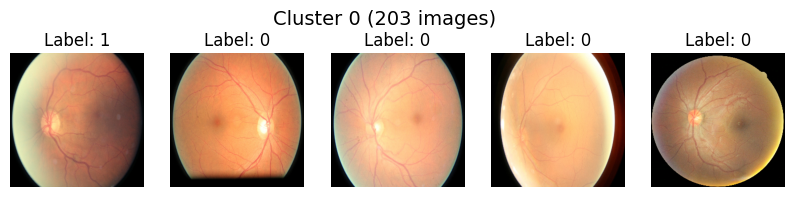

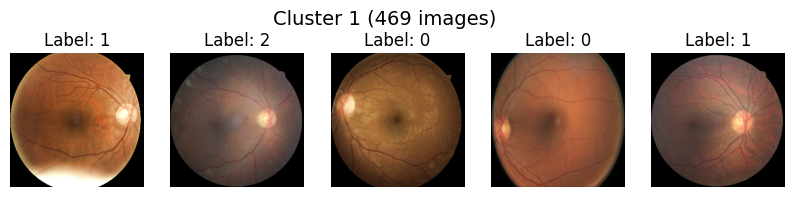

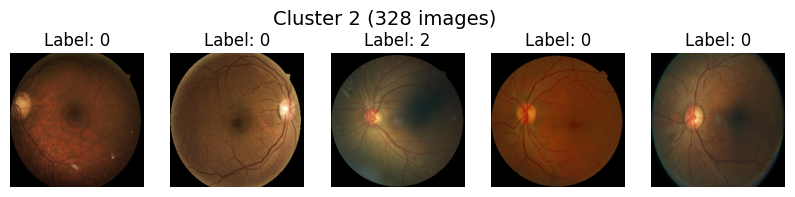

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

n_clusters = len(np.unique(seq_cust_kmeans.labels_ ))

for cluster in range(n_clusters):
    cluster_indices = np.where(seq_cust_kmeans.labels_ == cluster)[0]
    if len(cluster_indices) == 0:
        print(f"⚠️ Cluster {cluster} is empty — no images assigned.")
        continue

    n_samples = min(5, len(cluster_indices))
    sample_indices = random.sample(list(cluster_indices), n_samples)

    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
        # Convert one-hot encoded label to class index
        label_value = np.argmax(labels[idx])

        plt.title(f"Label: {label_value}")
    plt.suptitle(f"Cluster {cluster} ({len(cluster_indices)} images)", fontsize=14, y=1.05)
    plt.show()


In [ ]:
import numpy as np
unique, counts = np.unique(seq_cust_kmeans.labels_ , return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(0): np.int64(203), np.int64(1): np.int64(469), np.int64(2): np.int64(328)}


In [ ]:
# Normalisation [0, 1]
images_normalized = images / 255.0
images_flat_norm = images_normalized.reshape(len(images_normalized), -1)

# K-Means sur données normalisées
seq_cust_kmeans_norm = cust_K_Means(3, 300)
seq_cust_kmeans_norm.fit(images_flat_norm)

# Comparer les résultats
print("Sans normalisation:")
print(np.unique(seq_cust_kmeans.labels_, return_counts=True))
print("\nAvec normalisation:")
print(np.unique(seq_cust_kmeans_norm.labels_, return_counts=True))

KeyboardInterrupt: 

#ray

In [ ]:
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.0
    Uninstalling click-8.3.0:
      Successfully uninstalled click-8.3.0


In [ ]:
import numpy as np
import ray

@ray.remote
class Worker:
    """Ray worker for distributed K-Means computation"""

    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def compute_distances_and_assign(self, X_chunk, centroids):
        """
        Compute distances and assign clusters for a data chunk
        Returns: labels and partial centroid sums
        """
        centroids = np.array(centroids)
        X_chunk = np.array(X_chunk)

        # Vectorized distance computation
        distances = np.sqrt(((X_chunk[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2).sum(axis=2))
        labels = np.argmin(distances, axis=1)

        # Compute partial sums and counts for each cluster
        partial_sums = np.zeros((self.n_clusters, X_chunk.shape[1]))
        counts = np.zeros(self.n_clusters, dtype=int)

        for k in range(self.n_clusters):
            mask = labels == k
            counts[k] = np.sum(mask)
            if counts[k] > 0:
                partial_sums[k] = X_chunk[mask].sum(axis=0)

        return labels, partial_sums, counts



class K_Means_Distributed:
    """Distributed K-Means using Ray for parallel computation"""

    def __init__(self, n_clusters, max_iter=300, tol=1e-4, num_workers=4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.num_workers = num_workers
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None
        self.number_of_iter = 0

    def _initialize_centroids(self, X):
        """Randomly select initial centroids"""
        indices = np.random.permutation(X.shape[0])[:self.n_clusters]
        return X[indices].copy()

    def fit(self, X):
        """Train distributed K-Means on data X"""
        X = np.array(X)

        # Initialize Ray (done in main program as requested)
        # ray.init() should be called before creating K_Means_Distributed

        # Create workers
        workers = [Worker.remote(self.n_clusters) for _ in range(self.num_workers)]

        # Initialize centroids
        self.cluster_centers_ = self._initialize_centroids(X)

        # Split data into chunks for workers
        X_chunks = np.array_split(X, self.num_workers)
        chunk_refs = [ray.put(chunk) for chunk in X_chunks]

        for iteration in range(self.max_iter):
            # Distribute work: compute distances and assign clusters
            futures = [
                worker.compute_distances_and_assign.remote(chunk_ref, self.cluster_centers_)
                for worker, chunk_ref in zip(workers, chunk_refs)
            ]
            results = ray.get(futures)

            # Aggregate results from all workers
            all_labels = []
            total_sums = np.zeros((self.n_clusters, X.shape[1]))
            total_counts = np.zeros(self.n_clusters, dtype=int)

            for labels_chunk, partial_sums, counts in results:
                all_labels.extend(labels_chunk)
                total_sums += partial_sums
                total_counts += counts

            self.labels_ = np.array(all_labels)

            # Compute new centroids from aggregated data
            new_centers = np.zeros((self.n_clusters, X.shape[1]))
            for k in range(self.n_clusters):
                if total_counts[k] > 0:
                    new_centers[k] = total_sums[k] / total_counts[k]
                else:
                    # Handle empty cluster - reinitialize randomly
                    new_centers[k] = X[np.random.randint(X.shape[0])]

            # Check convergence
            if self.tol is not None:
                center_shift = np.sqrt(((new_centers - self.cluster_centers_) ** 2).sum())
                self.cluster_centers_ = new_centers

                if center_shift < self.tol:
                    self.number_of_iter = iteration + 1
                    print(f'Converged after {iteration + 1} iterations')
                    break
            else:
                self.cluster_centers_ = new_centers
        else:
            self.number_of_iter = self.max_iter
            print(f'Max iterations ({self.max_iter}) reached')

        return self

    def predict(self, X):
        """Predict cluster labels for new data (non-distributed for simplicity)"""
        X = np.array(X)
        distances = np.sqrt(((X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :]) ** 2).sum(axis=2))
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        """Fit and return cluster labels"""
        self.fit(X)
        return self.labels_

In [ ]:
import time
ray.init(num_cpus= 4)
print(ray.cluster_resources())
debut = time.time()
kmeans_dist = K_Means_Distributed(n_clusters=3, max_iter=500, num_workers=)
kmeans_dist.fit(images_flat)
fin = time.time()
print(f'temps d entrainement = {fin-debut:.2f} secondes')

2025-10-15 11:12:48,944	INFO worker.py:2013 -- Started a local Ray instance.


{'CPU': 4.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3989449113.0, 'memory': 9308714599.0}
Converged after 12 iterations
temps d entrainement = 46.60 secondes


In [ ]:
print(f"Nombre d'itérations effectuées: {kmeans_dist.number_of_iter}")

Nombre d'itérations effectuées: 9


In [ ]:
ray.shutdown()

#dask

In [ ]:
!pip install dask

In [ ]:
import numpy as np
from dask.distributed import Client

def _worker_compute(chunk, centroids):
    """
    Pure-Python worker function (runs on worker).
    Returns: labels (np.ndarray), partial_sums (np.ndarray), counts (np.ndarray)
    """
    chunk = np.array(chunk)
    centroids = np.array(centroids)

    # distances: (n_points_in_chunk, n_clusters)
    distances = np.sqrt(((chunk[:, np.newaxis, :] - centroids[np.newaxis, :, :]) ** 2).sum(axis=2))
    labels = np.argmin(distances, axis=1)

    n_clusters = centroids.shape[0]
    partial_sums = np.zeros((n_clusters, chunk.shape[1]))
    counts = np.zeros(n_clusters, dtype=int)

    for k in range(n_clusters):
        mask = labels == k
        counts[k] = mask.sum()
        if counts[k] > 0:
            partial_sums[k] = chunk[mask].sum(axis=0)

    return labels, partial_sums, counts


class KMeansDistributedDask:
    """
    Distributed KMeans using dask.distributed futures (scatter / submit / gather).
    Caller should create a dask Client before calling fit(), e.g.:
        client = Client()  # or Client(<scheduler-address>)
    """
    def __init__(self, n_clusters, max_iter=300, tol=1e-4, n_workers=4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.n_workers = n_workers
        self.random_state = random_state

        self.cluster_centers_ = None
        self.labels_ = None
        self.number_of_iter = 0

    def _initialize_centroids(self, X):
        rng = np.random.RandomState(self.random_state)
        indices = rng.permutation(X.shape[0])[:self.n_clusters]
        return X[indices].copy()

    def fit(self, X, client: Client):
        """
        Fit KMeans using an existing dask.distributed Client.
        - X: array-like (n_samples, n_features)
        - client: dask.distributed.Client (must be running)
        """
        X = np.array(X)
        n_samples, n_features = X.shape

        # initialize centroids
        self.cluster_centers_ = self._initialize_centroids(X)

        # split and scatter data chunks to workers (so we don't send big X every iteration)
        X_chunks = np.array_split(X, self.n_workers)
        # scatter returns futures that live on workers; pass these futures to submit to avoid re-transferring data
        scattered = client.scatter(X_chunks, broadcast=False)  # list of Futures
        # Note: scattered is a list of futures corresponding to chunks.

        for iteration in range(self.max_iter):
            # Submit a job for each chunk: each job receives the chunk future and the current centroids
            # Passing centroids directly (small) is fine; if centroids are large you could scatter them too.
            futures = [
                client.submit(_worker_compute, chunk_future, self.cluster_centers_)
                for chunk_future in scattered
            ]

            # Wait and gather results
            results = client.gather(futures)  # list of tuples (labels_chunk, partial_sums, counts)

            # Aggregate
            all_labels = []
            total_sums = np.zeros((self.n_clusters, n_features))
            total_counts = np.zeros(self.n_clusters, dtype=int)

            for labels_chunk, partial_sums, counts in results:
                all_labels.extend(labels_chunk.tolist() if isinstance(labels_chunk, np.ndarray) else labels_chunk)
                total_sums += partial_sums
                total_counts += counts

            # order-of-labels: since we used np.array_split and gathered in submission order,
            # the concatenation of labels corresponds to original X order.
            self.labels_ = np.array(all_labels)

            # compute new centers
            new_centers = np.zeros((self.n_clusters, n_features))
            for k in range(self.n_clusters):
                if total_counts[k] > 0:
                    new_centers[k] = total_sums[k] / total_counts[k]
                else:
                    # reinit empty cluster
                    new_centers[k] = X[np.random.randint(0, n_samples)]

            # compute centroid shift
            center_shift = np.sqrt(((new_centers - self.cluster_centers_) ** 2).sum())

            # update centroids
            self.cluster_centers_ = new_centers

            if center_shift < self.tol:
                self.number_of_iter = iteration + 1
                print(f'Converged after {iteration + 1} iterations')
                break
        else:
            self.number_of_iter = self.max_iter
            print(f'Max iterations ({self.max_iter}) reached')

        return self

    def predict(self, X):
        X = np.array(X)
        distances = np.sqrt(((X[:, np.newaxis, :] - self.cluster_centers_[np.newaxis, :, :]) ** 2).sum(axis=2))
        return np.argmin(distances, axis=1)

    def fit_predict(self, X, client: Client):
        self.fit(X, client)
        return self.labels_


In [ ]:
print("Starting Dask Client...")
client = Client(n_workers=2, threads_per_worker=1)
print(f"Dask Dashboard: {client.dashboard_link}")

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:40945
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41757'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:33977'


Starting Dask Client...


INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36991 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36991
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:34800
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:45775 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:45775
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:34802
INFO:distributed.scheduler:Receive client connection: Client-5cb87fc9-a9c0-11f0-9cea-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:34814


Dask Dashboard: http://127.0.0.1:8787/status


In [ ]:
import time
start = time.time()
kmeans_dask = KMeansDistributedDask(n_clusters=3, max_iter=500, n_workers=2)
kmeans_dask.fit(images_flat, client)
end = time.time()

print(f"Time taken: {end - start:.2f} seconds")
print(f"Iterations: {kmeans_dask.number_of_iter}")

Converged after 14 iterations
Time taken: 49.41 seconds
Iterations: 14


In [ ]:
client.close()

INFO:distributed.scheduler:Remove client Client-b83cf796-a9be-11f0-9cea-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:57382; closing.
INFO:distributed.scheduler:Remove client Client-b83cf796-a9be-11f0-9cea-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-b83cf796-a9be-11f0-9cea-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1760530390.5125234') (0,)
INFO:distributed.nanny:Closing Nanny at 'tcp://127.0.0.1:42045'. Reason: nanny-close
INFO:distributed.nanny:Nanny asking worker to close. Reason: nanny-close
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:57370; closing.
INFO:distributed.scheduler:Remove worker addr: tcp://127.0.0.1:43499 name: 0 (stimulus_id='handle-worker-cleanup-1760530390.5215201')
INFO:distributed.scheduler:Lost all workers
INFO:distributed.nanny:Nanny at 'tcp://127.0.0.1:42045' closed.
INFO:distributed.scheduler:Closing scheduler. Reason: unknown


#gpu

In [32]:
!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-405f3c51-72bc-83b0-9eb8-94265c5c58c3)


In [1]:
import numpy as np
import cupy as cp

class KMeans_GPU:
    """
    GPU-based K-Means using CuPy (CUDA).
    Works with a single GPU - parallelism is handled automatically by CUDA.
    """
    def __init__(self, n_clusters, max_iter=300, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state

        self.cluster_centers_ = None
        self.labels_ = None
        self.number_of_iter = 0

    def _initialize_centroids(self, X):
        """Initialize centroids on CPU then transfer to GPU"""
        if self.random_state is not None:
            np.random.seed(self.random_state)
        idx = np.random.permutation(X.shape[0])[:self.n_clusters]
        return X[idx].copy()

    def fit(self, X):
        """Train K-Means on GPU"""
        # Convert to numpy and transfer to GPU
        X = np.asarray(X, dtype=np.float32)
        X_gpu = cp.asarray(X)

        # Initialize centroids on GPU
        centroids_cpu = self._initialize_centroids(X)
        centroids_gpu = cp.asarray(centroids_cpu, dtype=cp.float32)

        for i in range(self.max_iter):
            # Step 1: Compute distances (GPU parallelizes automatically)
            # Shape: (n_samples, n_clusters)
            distances = cp.sqrt(
                ((X_gpu[:, cp.newaxis, :] - centroids_gpu[cp.newaxis, :, :]) ** 2).sum(axis=2)
            )

            # Step 2: Assign clusters (GPU)
            labels_gpu = cp.argmin(distances, axis=1)

            # Step 3: Compute new centroids (GPU)
            new_centroids = cp.zeros_like(centroids_gpu)

            for k in range(self.n_clusters):
                mask = labels_gpu == k
                count = cp.sum(mask)

                if count > 0:
                    new_centroids[k] = cp.mean(X_gpu[mask], axis=0)
                else:
                    # Empty cluster: reinitialize randomly
                    new_centroids[k] = X_gpu[cp.random.randint(0, X_gpu.shape[0])]

            # Step 4: Check convergence
            shift = cp.sqrt(cp.sum((new_centroids - centroids_gpu) ** 2))

            centroids_gpu = new_centroids

            if shift < self.tol:
                self.number_of_iter = i + 1
                print(f'✅ Converged after {i + 1} iterations')
                break
        else:
            self.number_of_iter = self.max_iter
            print(f'⚠️ Max iterations ({self.max_iter}) reached')

        # Transfer results back to CPU
        self.cluster_centers_ = cp.asnumpy(centroids_gpu)
        self.labels_ = cp.asnumpy(labels_gpu)

        return self

    def predict(self, X):
        """Predict cluster labels for new data"""
        X_gpu = cp.asarray(X, dtype=cp.float32)
        centroids_gpu = cp.asarray(self.cluster_centers_, dtype=cp.float32)

        distances = cp.sqrt(
            ((X_gpu[:, cp.newaxis, :] - centroids_gpu[cp.newaxis, :, :]) ** 2).sum(axis=2)
        )
        labels_gpu = cp.argmin(distances, axis=1)

        return cp.asnumpy(labels_gpu)

In [24]:
# Dans une cellule séparée, exécutez ceci PENDANT que K-Means tourne
!nvidia-smi

Sun Oct 19 12:37:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             31W /   70W |    7610MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import cupy as cp

print("=" * 50)
print("🔍 VÉRIFICATION GPU")
print("=" * 50)

try:
    print("✅ CuPy détecté !")
    print(f"CuPy version : {cp.__version__}")
    print(f"GPU disponible : {cp.cuda.is_available()}")

    if cp.cuda.is_available():
        # CORRECTION: Utiliser runtime au lieu de Device().name
        device = cp.cuda.Device(0)
        print(f"Nom du GPU : {cp.cuda.runtime.getDeviceProperties(device.id)['name'].decode()}")
        print(f"Compute Capability : {device.compute_capability}")

        # Mémoire GPU
        mempool = cp.get_default_memory_pool()
        free_mem, total_mem = cp.cuda.Device(0).mem_info
        print(f"Mémoire GPU libre : {free_mem / 1e9:.2f} GB")
        print(f"Mémoire GPU totale : {total_mem / 1e9:.2f} GB")
    else:
        print("❌ Aucun GPU disponible")

except Exception as e:
    print(f"❌ Erreur : {e}")

print("=" * 50)

🔍 VÉRIFICATION GPU
✅ CuPy détecté !
CuPy version : 13.3.0
GPU disponible : True
Nom du GPU : Tesla T4
Compute Capability : 75
Mémoire GPU libre : 15.72 GB
Mémoire GPU totale : 15.83 GB


In [18]:
# Entraînement
print("\n⚡ Début entraînement GPU...")
debut = time.time()

kmeans_gpu = KMeans_GPU(n_clusters=3, max_iter=300)
kmeans_gpu.fit(images_flat)

fin = time.time()
print(f"\n✅ Temps GPU = {fin-debut:.2f} secondes")


⚡ Début entraînement GPU...
✅ Converged after 11 iterations

✅ Temps GPU = 5.34 secondes


In [23]:
import numpy as np
import cupy as cp
import time

# Vérification GPU
print("=" * 50)
print("🔍 VÉRIFICATION GPU")
print("=" * 50)
print(f"CuPy version : {cp.__version__}")
print(f"GPU disponible : {cp.cuda.is_available()}")
if cp.cuda.is_available():
    #print(f"Nom du GPU : {cp.cuda.Device().name}")
    print(f"Compute Capability : {cp.cuda.Device().compute_capability}")
    mempool = cp.get_default_memory_pool()
    print(f"Mémoire GPU utilisée : {mempool.used_bytes() / 1e6:.2f} MB")
    print(f"Mémoire GPU totale : {mempool.total_bytes() / 1e6:.2f} MB")
print("=" * 50)

# Entraînement
print("\n⚡ Début entraînement GPU...")
debut = time.time()

kmeans_gpu = KMeans_GPU(n_clusters=3, max_iter=300)
kmeans_gpu.fit(images_flat)

fin = time.time()
print(f"\n✅ Temps GPU = {fin-debut:.2f} secondes")

# Vérifier mémoire après
mempool = cp.get_default_memory_pool()
print(f"📊 Mémoire GPU utilisée après fit : {mempool.used_bytes() / 1e6:.2f} MB")

🔍 VÉRIFICATION GPU
CuPy version : 13.3.0
GPU disponible : True
Compute Capability : 75
Mémoire GPU utilisée : 0.00 MB
Mémoire GPU totale : 7866.68 MB

⚡ Début entraînement GPU...
✅ Converged after 10 iterations

✅ Temps GPU = 1.52 secondes
📊 Mémoire GPU utilisée après fit : 0.00 MB


In [25]:
y_pred = kmeans_gpu.labels_

In [26]:
from sklearn.metrics import davies_bouldin_score
# Get predictions (cluster labels)
dbi_score = davies_bouldin_score(images_flat, y_pred)
print(f"Davies-Bouldin Index: {dbi_score:.4f}")

Davies-Bouldin Index: 1.4572


In [30]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(images_flat, y_pred)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Calinski-Harabasz Index: 455.1094


In [31]:
from sklearn.metrics import silhouette_score

# Compute silhouette score
score = silhouette_score(images_flat, y_pred)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.2161


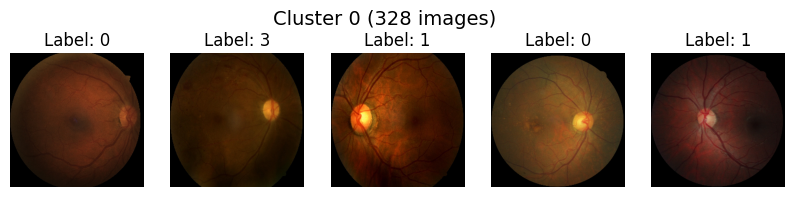

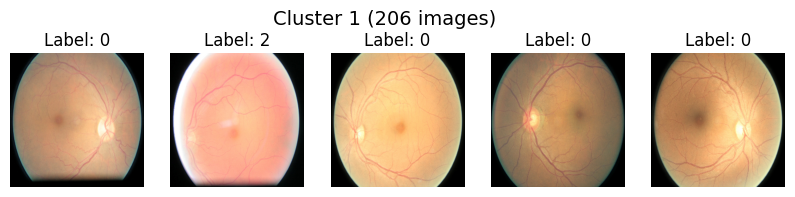

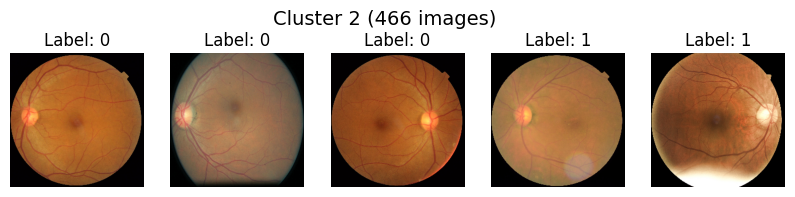

In [27]:
import matplotlib.pyplot as plt
import random
import numpy as np

n_clusters = len(np.unique(kmeans_gpu.labels_ ))

for cluster in range(n_clusters):
    cluster_indices = np.where(kmeans_gpu.labels_ == cluster)[0]
    if len(cluster_indices) == 0:
        print(f"⚠️ Cluster {cluster} is empty — no images assigned.")
        continue

    n_samples = min(5, len(cluster_indices))
    sample_indices = random.sample(list(cluster_indices), n_samples)

    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(sample_indices):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(images[idx])
        plt.axis('off')
        # Convert one-hot encoded label to class index
        label_value = np.argmax(labels[idx])

        plt.title(f"Label: {label_value}")
    plt.suptitle(f"Cluster {cluster} ({len(cluster_indices)} images)", fontsize=14, y=1.05)
    plt.show()

#parsl

In [33]:
# Dans un notebook Colab, exécutez :
!pip freeze > requirements.txt

In [34]:
# Télécharger le fichier
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import cupy as cp
import sys

print("=" * 60)
print("🔥 INFORMATIONS GPU/CUDA/CuPy")
print("=" * 60)

# Version Python
print(f"Python        : {sys.version.split()[0]}")

# Version CuPy
print(f"CuPy          : {cp.__version__}")

# Version CUDA (runtime)
cuda_version = cp.cuda.runtime.runtimeGetVersion()
print(f"CUDA Runtime  : {cuda_version // 1000}.{(cuda_version % 1000) // 10}")

# Version CUDA (driver)
driver_version = cp.cuda.runtime.driverGetVersion()
print(f"CUDA Driver   : {driver_version // 1000}.{(driver_version % 1000) // 10}")

# Informations GPU
device = cp.cuda.Device(0)
print(f"GPU Name      : {cp.cuda.runtime.getDeviceProperties(device.id)['name'].decode()}")
print(f"GPU ID        : {device.id}")
print(f"Compute Cap.  : {device.compute_capability}")

# Mémoire GPU
free_mem, total_mem = device.mem_info
print(f"GPU Memory    : {total_mem / 1e9:.2f} GB total")
print(f"GPU Free      : {free_mem / 1e9:.2f} GB free")
print(f"GPU Used      : {(total_mem - free_mem) / 1e9:.2f} GB used")

print("=" * 60)

🔥 INFORMATIONS GPU/CUDA/CuPy
Python        : 3.12.12
CuPy          : 13.3.0
CUDA Runtime  : 12.6
CUDA Driver   : 12.4
GPU Name      : Tesla T4
GPU ID        : 0
Compute Cap.  : 75
GPU Memory    : 15.83 GB total
GPU Free      : 15.72 GB free
GPU Used      : 0.11 GB used
